# ML on ESDC using PyTorch 
A DeepESDL example notebook

## Linear Regression for prediction of missing land surface temperature values from air temperature values
This notebook demonstrates how to implement Machine Learning on the Earth System Data Cube using the ML library PyTorch. The workflow is self-contained and based on a generic use case to showcase data loading, sampling strategies, model training, model evaluation and visualisation.

Please, also refer to the DeepESDL documentation and visit the platform's website for further information!

ScaDS.AI, 2023

### Import necessary libraries
In case you experience an error due to a missing library xy, please install it via "pip install xy".

In [1]:
import math
import numpy as np
import mlflow
import xarray as xr
from xcube.core.store import new_data_store

import mltools as ml
import pandas as pd

import dask.array as da

import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from torch.nn.functional import normalize

from global_land_mask import globe
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

/home/anjaneumann/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Data (Earth System Data Cube)
We load the ESDC (*.zarr) from the s3 data store (lazy load). The ESDC consists of three dimensions (longitude, latitude, time). Out of many available cube variables, which are dask arrays, we load two ("land_surface_temperature", "air_temperature_2m"). 

In [2]:
data_store = new_data_store("s3", root="esdl-esdc-v2.1.1", storage_options=dict(anon=True))
dataset = data_store.open_data('esdc-8d-0.083deg-184x270x270-2.1.1.zarr')
ds = dataset[['land_surface_temperature', 'air_temperature_2m']]
ds

,Array,Chunk
Bytes,63.96 GiB,51.17 MiB
Shape,"(1840, 2160, 4320)","(184, 270, 270)"
Count,1281 Tasks,1280 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,63.96 GiB,51.17 MiB
Shape,"(1840, 2160, 4320)","(184, 270, 270)"
Count,1281 Tasks,1280 Chunks
Type,float32,numpy.ndarray


### Add land mask variable 
Here we exclude redundant water surface values for our use case and only consider solid Earth data for our ML analysis. We extend the ESDC by a new variable "land_mask". The mask is a data array initialized for one time slice of the ESDC. 

In [3]:
lon_grid, lat_grid = np.meshgrid(ds.lon,ds.lat)
lm0 = da.from_array(globe.is_land(lat_grid, lon_grid))
lm0

dask.array<array, shape=(2160, 4320), dtype=bool, chunksize=(2160, 4320), chunktype=numpy.ndarray>

We now extend the mask to all time slices of the ESDC.

In [4]:
lm = da.stack([lm0 for i in range(ds.dims['time'])], axis = 0)
lm

dask.array<stack, shape=(10, 2160, 4320), dtype=bool, chunksize=(1, 2160, 4320), chunktype=numpy.ndarray>

We add the mask as variable to the ESDC. The cube now consists of three equally chunked variables ("land_surface_temperature", "air_temperature_2m", "land_mask"). 

In [5]:
xdsm = ds.assign(land_mask= (['time','lat','lon'],lm.rechunk(chunks=([v for k,v in ml.get_chunk_sizes(ds)]))))
xdsm

<xarray.Dataset>
Dimensions:                   (time: 10, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 2002-05-21 ... 2002-08-01
Data variables:
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    land_mask                 (time, lat, lon) bool dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

### Plot masked data for one time slice
To do that we convert the cube to a pandas dataframe.

In [6]:
df = xdsm.sel({'time' : '2002-05-21'}).to_dataframe()
df

air_temperature_2m  land_surface_temperature  \
lat        lon                                                         
 89.958333 -179.958333          266.297180                       NaN   
           -179.875000          266.297180                       NaN   
           -179.791667          266.297180                       NaN   
           -179.708333          266.297180                       NaN   
           -179.625000          266.297180                       NaN   
...                                    ...                       ...   
-89.958333  179.625000          219.817398                       NaN   
            179.708333          219.817398                       NaN   
            179.791667          219.817398                       NaN   
            179.875000          219.817398                       NaN   
            179.958333          219.817398                       NaN   

                             time  land_mask  
lat        lon                                
 89.958333 -179.958333 2002-05-21      False  
           -179.875000 2002-05-21      False  
           -179.791667 2002-05-21      False  
           -179.708333 2002-05-21      False  
           -179.625000 2002-05-21      False  
...                           ...        ...  
-89.958333  179.625000 2002-05-21       True  
            179.708333 2002-05-21       True  
            179.791667 2002-05-21       True  
            179.875000 2002-05-21       True  
            179.958333 2002-05-21       True  

[9331200 rows x 4 columns]

Air Temperature

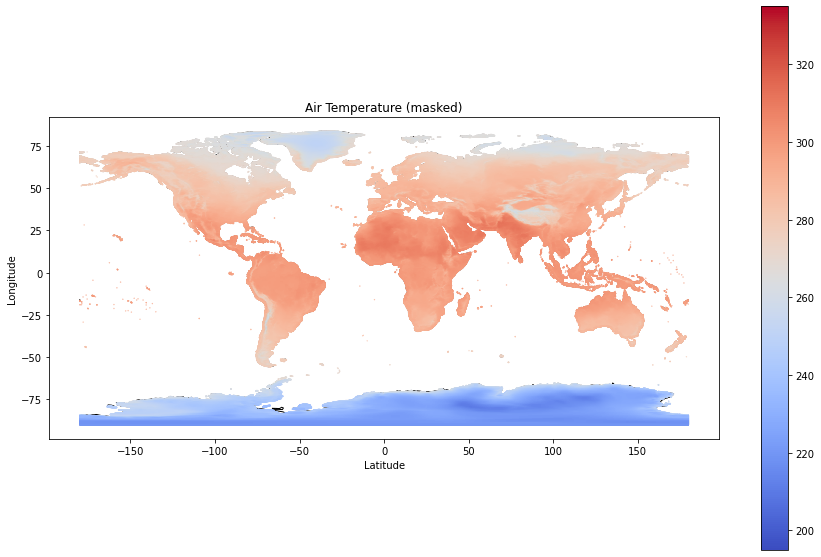

In [7]:
dfdn = df[df['land_mask'] == True]
dfdn = dfdn.reset_index()

geometry = [Point(xy) for xy in zip(dfdn['lon'], dfdn['lat'])]
gdf = GeoDataFrame(dfdn, geometry=geometry) 

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(figsize=(15, 10), markersize = 0.1,
    ax=world.plot(figsize=(15, 10), color='white', edgecolor='black'),
        column = 'air_temperature_2m', cmap = 'coolwarm', legend = True, legend_kwds={
        "shrink":.5, 'label': 'Air Temperature [K]'});

plt.title('Air Temperature')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
#plt.savefig('air_temp_masked.png')

Land Surface Temperature

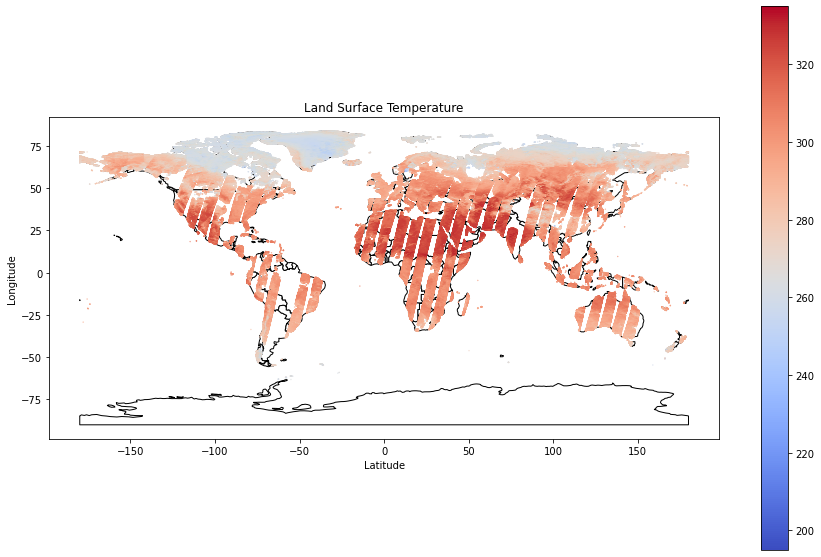

In [7]:
dfdn = df[df['land_mask'] == True]
dfdn = dfdn.reset_index()

geometry = [Point(xy) for xy in zip(dfdn['lon'], dfdn['lat'])]
gdf = GeoDataFrame(dfdn, geometry=geometry) 

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(figsize=(15, 10), markersize = 0.1,
    ax=world.plot(figsize=(15, 10), color='white', edgecolor='black'),
        column = 'land_surface_temperature', cmap = 'coolwarm', legend = True, legend_kwds={
        "shrink":.5, 'label': 'Land Surface Temperature [K]'});

plt.title('Land Surface Temperature')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
#plt.savefig('land_surface_temperature.png')

### Assign train/test split
Here you can choose between random sampling and block sampling. Based on the use case, the application of ML analyses on remotely sensed data is prone to autocorrelation, especially when the data is split randomly. Block sampling is one strategy to deal with autocorrelation.

In [6]:
# random sampling
#xds = xdsm.assign({"split": ml.rand})
#xds

# block sampling
xds = ml.assign_split(xdsm, block_size=[("time", 10), ("lat", 100), ("lon", 100)], split=0.7)
xds

<xarray.Dataset>
Dimensions:                   (time: 10, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 2002-05-21 ... 2002-08-01
Data variables:
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    land_mask                 (time, lat, lon) bool dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    split                     (time, lat, lon) float64 dask.array<chunksize=(10, 100, 100), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

Plot train/test assignment

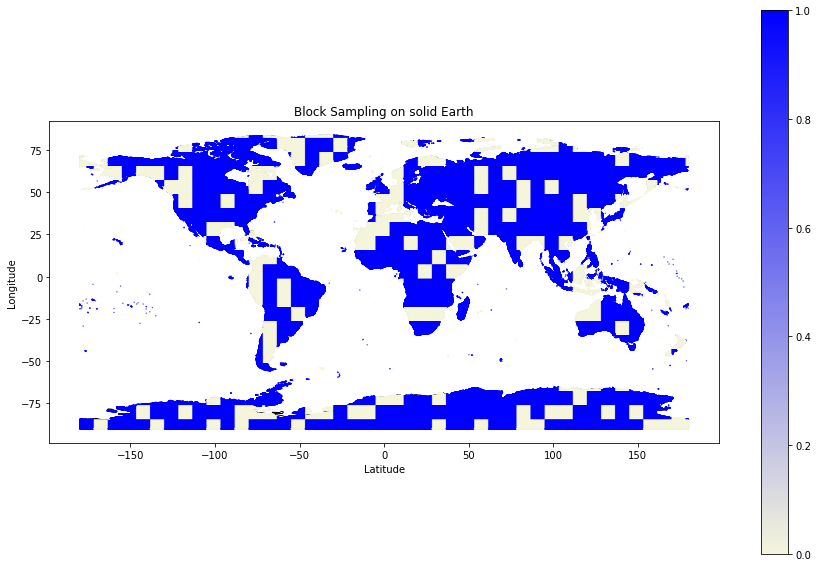

In [8]:
df = xds.sel({'time' : '2002-05-21'}).to_dataframe()

dfdn = df[df['land_mask'] == True]
dfdn = dfdn.reset_index()

geometry = [Point(xy) for xy in zip(dfdn['lon'], dfdn['lat'])]
gdf = GeoDataFrame(dfdn, geometry=geometry) 

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(figsize=(15, 10), markersize = 0.1,
    ax=world.plot(figsize=(15, 10), color='white', edgecolor='black'),
    column = 'split', cmap = LinearSegmentedColormap.from_list("", ["beige","blue"]), legend = True, legend_kwds={
        "shrink":.5, 'label': 'train/test assignment', 'ticks': [0,1]}) 

plt.title('Block Sampling')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
#plt.savefig('train_test_assignment.png')

### Model set up

Select cuda device if available to use GPU ressources

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


#### Initialize MLFlow experiment

In [8]:
experiment_name = "Pytorch Linear Regression of LST from AT with mlflow"
mlflow.set_experiment(experiment_name)

current_experiment=dict(mlflow.get_experiment_by_name(experiment_name))
experiment_id = current_experiment['experiment_id']

2023/05/02 18:34:56 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/05/02 18:34:56 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


#### Define model, loss and optimizer

In [9]:
lr = 0.0001
epochs = 3

reg_model = nn.Linear(in_features=1, out_features=1, bias=True)
mse_loss = nn.MSELoss()
optimizer = torch.optim.SGD(reg_model.parameters(), lr=lr)

Get range (min, max) and statistics (mean, std) of data variables for normalization or standardization.

In [10]:
at_range = ml.getRange(ds, 'air_temperature_2m')
lst_range = ml.getRange(ds, 'land_surface_temperature')

at_stat = ml.getStatistics(ds, 'air_temperature_2m')
lst_stat = ml.getStatistics(ds, 'land_surface_temperature')

### Train model

We iterate through the chunks of the ESDC. The data will be preprocessed by flattening, choosing values, removing NaNs, normalization or standardization. Further, we will split the data into a training and testing fraction. We generate a train data loader and a test data loader and perform a linear regression. The train and test errors are returned during model training.

In [11]:
with mlflow.start_run(experiment_id=experiment_id) as run:
    
    mlflow.log_param('lr', lr)
    mlflow.log_param('number_epochs', epochs)
    
    for chunk in ml.iter_data_var_blocks(xds): 
        ### preprocessing 
        # flatten
        cf = {x: chunk[x].ravel() for x in chunk.keys()}
        # choose land values
        lm = cf['land_mask']
        cft = {x: cf[x][lm == True] for x in cf.keys()}
        # drop nans
        lst = cft['land_surface_temperature']
        cfn = {x: cft[x][~np.isnan(lst)] for x in cf.keys()}

        if len(cfn['land_surface_temperature']) > 0:
            #X = normalize(cfn['air_temperature_2m'], 'air_temperature_2m')
            #y = normalize(cfn['land_surface_temperature'], 'land_surface_temperature')
            X = ml.standardize(cfn['air_temperature_2m'],*at_stat)
            y = ml.standardize(cfn['land_surface_temperature'], *lst_stat)

            ### get train/test data 
            X_train = X[cfn['split']==True]
            X_test  = X[cfn['split']==False]
            y_train = y[cfn['split']==True]
            y_test  = y[cfn['split']==False]

            if len(X_train) > 0:
                train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
                trainloader = DataLoader(train_ds, batch_size=50, shuffle=True)
                
            if len(X_test) > 0:
                test_ds  = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
                testloader  = DataLoader(test_ds, batch_size=50, shuffle=True)

            ### train model 
            for i in range(1, epochs + 1):
                if len(X_train) > 0:
                    reg_model, train_pred,loss = ml.train_one_epoch(i, trainloader, reg_model, mse_loss, optimizer, device)
                    mlflow.log_metric('train_loss', loss)
                    print(f"Training Error: Avg loss: {loss:>8f}")
                if len(X_test) > 0:
                    test_pred, test_loss = ml.test(testloader, reg_model, mse_loss, device)
                    mlflow.log_metric('test_loss', test_loss)
                    print(f"Test Error: Avg loss: {test_loss:>8f} \n")

Training Error: Avg loss: 0.000000
Test Error: Avg loss: 1.044608 

Training Error: Avg loss: 0.000000
Test Error: Avg loss: 0.890217 

Training Error: Avg loss: 0.000000
Test Error: Avg loss: 0.761887 

Training Error: Avg loss: 0.598109
Training Error: Avg loss: 0.377675
Training Error: Avg loss: 0.263120
Training Error: Avg loss: 0.267634
Test Error: Avg loss: 0.352484 

Training Error: Avg loss: 0.197002
Test Error: Avg loss: 0.242893 

Training Error: Avg loss: 0.163554
Test Error: Avg loss: 0.183502 

Training Error: Avg loss: 0.115497
Training Error: Avg loss: 0.079341
Training Error: Avg loss: 0.070603
Training Error: Avg loss: 0.062896
Test Error: Avg loss: 0.083204 

Training Error: Avg loss: 0.062416
Test Error: Avg loss: 0.081889 

Training Error: Avg loss: 0.061735
Test Error: Avg loss: 0.081388 

Training Error: Avg loss: 0.043131
Test Error: Avg loss: 0.033709 

Training Error: Avg loss: 0.041128
Test Error: Avg loss: 0.032853 

Training Error: Avg loss: 0.039982
Test Er

### Launch MLFlow UI

In [ ]:
!mlflow ui 
#jupyterhub: visit https://mlflow-8a63c7.deep.earthsystemdatalab.net/
#visit http://localhost:5000
#this can be done in terminal simultaneously to calculating epochs

[2023-05-02 19:06:52 +0000] [6658] [INFO] Starting gunicorn 20.1.0
[2023-05-02 19:06:52 +0000] [6658] [INFO] Listening at: http://127.0.0.1:5000 (6658)
[2023-05-02 19:06:52 +0000] [6658] [INFO] Using worker: sync
[2023-05-02 19:06:52 +0000] [6659] [INFO] Booting worker with pid: 6659
[2023-05-02 19:06:52 +0000] [6660] [INFO] Booting worker with pid: 6660
[2023-05-02 19:06:52 +0000] [6661] [INFO] Booting worker with pid: 6661
[2023-05-02 19:06:52 +0000] [6662] [INFO] Booting worker with pid: 6662


### Model Predictions

Get Air Temperature values for Lon/Lat with missing Land Surface Temperature values

In [12]:
df = xds.sel({'time' : '2002-05-21'}).to_dataframe()
df

air_temperature_2m  land_surface_temperature  \
lat        lon                                                         
 89.958333 -179.958333          266.297180                       NaN   
           -179.875000          266.297180                       NaN   
           -179.791667          266.297180                       NaN   
           -179.708333          266.297180                       NaN   
           -179.625000          266.297180                       NaN   
...                                    ...                       ...   
-89.958333  179.625000          219.817398                       NaN   
            179.708333          219.817398                       NaN   
            179.791667          219.817398                       NaN   
            179.875000          219.817398                       NaN   
            179.958333          219.817398                       NaN   

                             time  land_mask  split  
lat        lon                                       
 89.958333 -179.958333 2002-05-21      False    0.0  
           -179.875000 2002-05-21      False    0.0  
           -179.791667 2002-05-21      False    0.0  
           -179.708333 2002-05-21      False    0.0  
           -179.625000 2002-05-21      False    0.0  
...                           ...        ...    ...  
-89.958333  179.625000 2002-05-21       True    0.0  
            179.708333 2002-05-21       True    0.0  
            179.791667 2002-05-21       True    0.0  
            179.875000 2002-05-21       True    0.0  
            179.958333 2002-05-21       True    0.0  

[9331200 rows x 5 columns]

Predict missing Land Surface Temperature values from Air Temperature values

In [13]:
dfl = df[df['land_mask'] == True]
orig = dfl.dropna()
to_pred = dfl[np.isnan(dfl['land_surface_temperature'])]
output = to_pred.drop('land_surface_temperature', axis = 1)

X = ml.standardize(to_pred['air_temperature_2m'], *at_stat)
X = X.values

lstp = reg_model(torch.tensor(X.reshape(-1, 1)))
output['land_surface_temperature'] = ml.undo_standardizing(lstp.detach().cpu().numpy(), *lst_stat)
output

air_temperature_2m       time  land_mask  split  \
lat        lon                                                            
 83.208333 -73.958333           266.152954 2002-05-21       True    1.0   
 83.125000 -77.041667           265.867096 2002-05-21       True    1.0   
           -76.958333           265.832367 2002-05-21       True    1.0   
           -76.875000           265.832367 2002-05-21       True    1.0   
           -76.791667           265.832367 2002-05-21       True    1.0   
...                                    ...        ...        ...    ...   
-89.958333  179.625000          219.817398 2002-05-21       True    0.0   
            179.708333          219.817398 2002-05-21       True    0.0   
            179.791667          219.817398 2002-05-21       True    0.0   
            179.875000          219.817398 2002-05-21       True    0.0   
            179.958333          219.817398 2002-05-21       True    0.0   

                        land_surface_temperature  
lat        lon                                    
 83.208333 -73.958333                 268.473846  
 83.125000 -77.041667                 268.198883  
           -76.958333                 268.165466  
           -76.875000                 268.165466  
           -76.791667                 268.165466  
...                                          ...  
-89.958333  179.625000                223.904419  
            179.708333                223.904419  
            179.791667                223.904419  
            179.875000                223.904419  
            179.958333                223.904419  

[1739067 rows x 5 columns]

### Plot Predictions

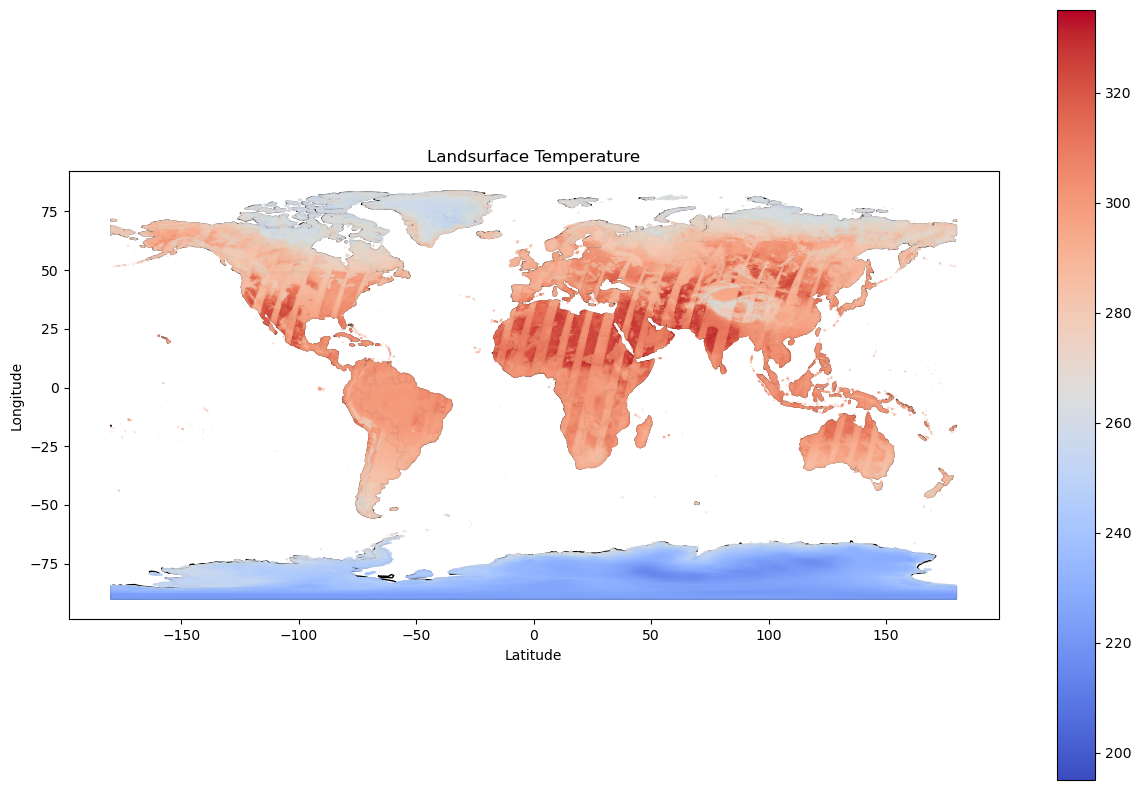

In [15]:

df = pd.concat([orig['land_surface_temperature'], output['land_surface_temperature']])
lst = df.reset_index()

geometry = [Point(xy) for xy in zip(lst['lon'], lst['lat'])]
gdf = GeoDataFrame(lst, geometry=geometry) 

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(figsize=(15, 10), markersize = 0.1,
    ax=world.plot(figsize=(15, 10), color='white', edgecolor='black'),
        column = 'land_surface_temperature', cmap = 'coolwarm', legend = True, legend_kwds={
        "shrink":.5, 'label': 'Land Surface Temperature [K]'});

plt.title('Landsurface Temperature');
plt.xlabel('Latitude');
plt.ylabel('Longitude');
#fname = 'xxx' +'.png'
#plt.savefig(fname)
plt.show()